In [1]:
import sys

sys.path.insert(0, "../methods")

import numpy as np
from VAMPClass import VAMP
from AnalyticalMappingEntropyClass import AME
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Soft Center

kirchoff_matrix = [[ 10,-10,  0,  0], 
                   [-10, 11, -1,  0], 
                   [  0, -1, 11,-10], 
                   [  0,  0,-10, 10]]
# Soft edges

# kirchoff_matrix = [[  1, -1,  0,  0], 
#                    [ -1,  2, -1,  0], 
#                    [  0, -1,  2, -1], 
#                    [  0,  0, -1,  1]]

In [3]:
vamp = VAMP(kirchoff_matrix, n_beads=2)
vamp.compute_vamp(100)
vamp_results, lagtime = vamp.return_vamp_scores()

In [4]:
ame = AME(kirchoff_matrix)
ame.compute_ame()
ame_results = ame.return_ame_scores()
vp_results = ame.return_vp_scores()

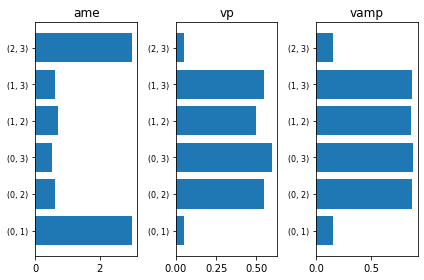

In [5]:
results = [ame_results, vp_results, vamp_results]
titles = ["ame", "vp", "vamp"]
fig, ax = plt.subplots(nrows=1, ncols=len(titles), tight_layout=True)

for ia, aa in enumerate(ax):
    keys = list(results[ia].keys())
    values = results[ia].values()
    y = np.arange(len(values))
    aa.barh(y, values)
    aa.set_yticks(y, keys, fontsize=8, rotation=0)
    aa.set_title(titles[ia])

In [6]:
## Determine optimal stratgies
optimal_mappings = {}
for i_r,result in enumerate(results):
    optimal_mappings[titles[i_r]] = []
    keys = list(results[i_r].keys())
    values = np.array(list(results[i_r].values()))
    max_inds = np.where(values==values.max())[0]
    
    ## Handle degeneracies
    for max_ind in max_inds:
        max_ind = int(max_ind)
        optimal_mappings[titles[i_r]].append(keys[max_ind])

In [25]:
def color_nodes(n_atoms,optimal_mapping):
    colors = n_atoms*['b']
    for inds in optimal_mapping:
        for ind in inds:
            colors[ind] = 'r'
    return colors

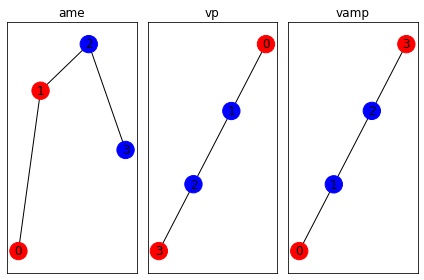

In [28]:
fig,ax = plt.subplots(ncols=len(titles),tight_layout=True)
graph = vamp.graph

for ia,aa in enumerate(ax):
    colors = color_nodes(vamp.n_atoms,optimal_mappings[titles[ia]])
    nx.draw_networkx(graph,node_color=colors,ax=aa)
    aa.set_title(titles[ia])